## ⚙️ Step 1: Install Required Libraries

We'll use the following packages:
- `sentence-transformers` to load the BERT model and generate embeddings
- `scikit-learn` for training the SVM classifier and evaluating with cross-validation

In [1]:
#pip install -U sentence-transformers scikit-learn

## 📂 Step 2: Load and Prepare Dataset

We will:
- Load the dataset of 105 research abstracts
- Merge the `Title` and `Abstract` into a single input text field
- Extract the input (`text`) and target (`methodology`) variables for classification

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Data/NLP_Dataset_Title_Abstract_Discipline_Subfield_Methodology.csv")

# Merge Title + Abstract into one input text field
df["text"] = df["Title"].fillna('') + " " + df["Abstract"].fillna('')
df["text"] = df["text"].str.strip()

# Drop rows where Methodology label is missing
df = df.dropna(subset=["Methodology"])

# Extract features and labels
texts = df["text"].tolist()
labels = df["Methodology"].tolist()

# Preview
print(f"✅ Loaded {len(texts)} samples.")
print(f"🔖 Unique methodology labels: {set(labels)}")

✅ Loaded 105 samples.
🔖 Unique methodology labels: {'Qualitative', 'Quantitative', 'Mixed'}


## 🤖 Step 3: Load Sentence-BERT Model

We'll now load the pretrained Sentence-BERT model `all-MiniLM-L6-v2`, which converts each abstract into a 768-dimensional dense vector that captures semantic meaning.

In [3]:
from sentence_transformers import SentenceTransformer

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')
print("✅ Model loaded successfully.")

✅ Model loaded successfully.


## 🧬 Step 4: Generate Sentence Embeddings

We'll now convert each research abstract into a 768-dimensional vector using the pretrained Sentence-BERT model. These vectors will be used as input features for the SVM classifier.

In [4]:
# Convert all texts to dense BERT embeddings
X = model.encode(texts, show_progress_bar=True)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

## 📊 Step 5: Train and Evaluate Using SVM with Cross-Validation

We'll train a linear Support Vector Machine (SVM) on the Sentence-BERT embeddings.
We use 5-fold stratified cross-validation and compute the mean accuracy and standard deviation.

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

# Define the SVM classifier
svm = SVC(kernel='linear', class_weight='balanced', random_state=42)

# Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model
scores = cross_val_score(svm, X, labels, cv=cv)

# Display results
print("📊 Fold Accuracies:", scores)
print("✅ Mean Accuracy:", round(np.mean(scores), 4))
print("📉 Std Deviation:", round(np.std(scores), 4))

📊 Fold Accuracies: [0.52380952 0.57142857 0.33333333 0.28571429 0.47619048]
✅ Mean Accuracy: 0.4381
📉 Std Deviation: 0.1102


## 🤔 Step 6: Try Logistic Regression on BERT Embeddings

Since SVM may not be the best fit for dense BERT embeddings on small datasets, we’ll now try a Logistic Regression classifier.
We’ll use the same 5-fold stratified cross-validation setup and compare accuracy with our earlier SVM results.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Define Logistic Regression with balanced class weights
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Cross-validation using the same setup
scores = cross_val_score(logreg, X, labels, cv=cv)

# Show results
print("📊 Fold Accuracies:", scores)
print("✅ Mean Accuracy:", round(np.mean(scores), 4))
print("📉 Std Deviation:", round(np.std(scores), 4))

📊 Fold Accuracies: [0.52380952 0.47619048 0.33333333 0.33333333 0.47619048]
✅ Mean Accuracy: 0.4286
📉 Std Deviation: 0.0797


## 🔁 Step 7: Normalize BERT Embeddings Before Training

We'll apply `StandardScaler` to the Sentence-BERT embeddings before passing them into our classifiers. This ensures that each feature (dimension) has zero mean and unit variance — a common preprocessing step for models like SVM and Logistic Regression.

In [7]:
from sklearn.preprocessing import StandardScaler

# Normalize the BERT embeddings
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Re-evaluate using Logistic Regression on scaled embeddings
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
scores = cross_val_score(logreg, X_scaled, labels, cv=cv)

# Display results
print("📊 Fold Accuracies:", scores)
print("✅ Mean Accuracy (Scaled):", round(np.mean(scores), 4))
print("📉 Std Deviation:", round(np.std(scores), 4))

📊 Fold Accuracies: [0.52380952 0.52380952 0.42857143 0.57142857 0.57142857]
✅ Mean Accuracy (Scaled): 0.5238
📉 Std Deviation: 0.0522


## ✅ Summary of Results – Sentence-BERT vs TF-IDF for Methodology Classification

### Baseline Model (TF-IDF + SVM)
- Notebook: `methodology_classifier_v2.0.ipynb`
- Preprocessing: TF-IDF (unigram/bigram)
- Classifier: Support Vector Machine (linear kernel, SMOTE applied)
- 5-Fold CV Mean Accuracy: **0.71**

---

### Experiment 1: Sentence-BERT + SVM (Unscaled)
- Notebook: `methodology_classifier_(v2.1)_bert.ipynb`
- Embeddings: `all-MiniLM-L6-v2` (768-dim)
- Classifier: SVM (linear, class_weight='balanced')
- 5-Fold CV Mean Accuracy: **0.4381**
- Std Deviation: **0.1102**

---

### Experiment 2: Sentence-BERT + Logistic Regression (Unscaled)
- Same notebook as above
- Classifier: Logistic Regression (balanced, max_iter=1000)
- 5-Fold CV Mean Accuracy: **0.4286**
- Std Deviation: **0.0797**

---

### ✅ Experiment 3: Sentence-BERT + Logistic Regression (Scaled)
- Notebook: `methodology_classifier_(v2.1.1)_bert_scaled_logreg.ipynb`
- Preprocessing: StandardScaler on embeddings
- Classifier: Logistic Regression (balanced, max_iter=1000)
- 5-Fold CV Mean Accuracy: **0.5238**
- Std Deviation: **0.0522**

---

### 🔍 Insight:
- TF-IDF still outperforms all BERT-based methods on this small dataset.
- Normalizing BERT embeddings significantly improved performance.
- Logistic Regression is better suited than SVM in this context.

## 💾 Save Finalized Model and Scaler

We'll save the trained Logistic Regression model and the StandardScaler using `joblib`, so they can be reused or evaluated later.

In [8]:
import joblib

# Save the scaler and model (retrain on full data before saving)
logreg_final = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg_final.fit(X_scaled, labels)

# Save model and scaler
joblib.dump(logreg_final, 'Artefacts/methodology_logreg_v2.1.1_scaled.pkl')
joblib.dump(scaler, 'Artefacts/methodology_scaler_v2.1.1.pkl')

print("✅ Model and scaler saved.")

✅ Model and scaler saved.


In [9]:
!pip install matplotlib
import matplotlib.pyplot as plt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


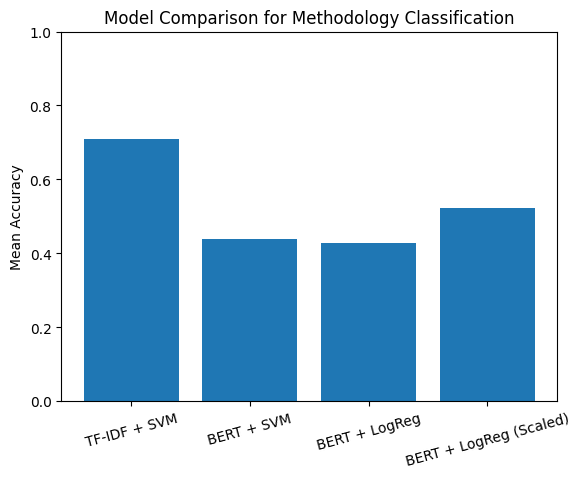

In [10]:
models = ['TF-IDF + SVM', 'BERT + SVM', 'BERT + LogReg', 'BERT + LogReg (Scaled)']
accuracies = [0.71, 0.4381, 0.4286, 0.5238]

plt.bar(models, accuracies)
plt.ylabel("Mean Accuracy")
plt.ylim(0, 1)
plt.title("Model Comparison for Methodology Classification")
plt.xticks(rotation=15)
plt.show()